In [22]:
from __future__ import print_function
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
#Seed 
random_seed = random.randint(0,10000)
print("Random Seed : ", random_seed)
random.seed(random_seed)
torch.manual_seed(random_seed)

Random Seed :  1449


In [4]:
#Arguments 
data = '/media/shubhansh/Storage/Datasets/CelebA/'
workers = 4
batch_size = 128
img_size = 64
n_channel = 3
n_z = 100
n_fpg = 64
n_fpd = 64
n_epochs = 5
lr = 0.0002
beta1 = 0.5
ngpu = 1

In [10]:
dataset  = dset.ImageFolder(root = data,transform = transforms.Compose([transforms.Resize(img_size),transforms.CenterCrop(img_size),transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]))
dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True,num_workers=workers)
device = torch.device("cuda:0")


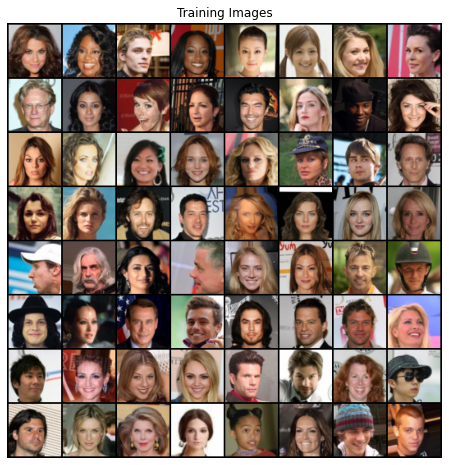

In [12]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64],padding=2,normalize=True).cpu(),(1,2,0)))

In [17]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv')!=-1:
        nn.init.normal_(m.weight.data,0.0,0.02)
    elif classname.find('BatchNorm')!=-1:
        nn.init.normal_(m.weight.data,1.0,0.02)
        nn.init.constant_(m.bias.data,0)

In [27]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.convt1 = nn.ConvTranspose2d(n_z,n_fpg*8,4,1,0,bias = False)
        self.bn1 = nn.BatchNorm2d(n_fpg*8)

        self.convt2 = nn.ConvTranspose2d(n_fpg*8,n_fpg*4,4,2,1,bias = False)
        self.bn2 = nn.BatchNorm2d(n_fpg*4)

        self.convt3 = nn.ConvTranspose2d(n_fpg*4,n_fpg*2,4,2,1,bias = False)
        self.bn3 = nn.BatchNorm2d(n_fpg*2)

        self.convt4 = nn.ConvTranspose2d(n_fpg*2,n_fpg,4,2,1,bias = False)
        self.bn4 = nn.BatchNorm2d(n_fpg)

        self.convt5 = nn.ConvTranspose2d( n_fpg, n_channel, 4, 2, 1, bias=False)

    
    def forward(self,input):

        o1_1 = self.convt1(imput)
        o1_2 = self.bn1(o1_1)
        o1_3 = F.relu(o1_2)

        o2_1 = self.convt2(o1_3)
        o2_2 = self.bn2(o2_1)
        o2_3 = F.relu(o2_2)

        o3_1 = self.convt3(o2_3)
        o3_2 = self.bn3(o3_1)
        o3_3 = F.relu(o3_2)

        o4_1 = self.convt4(o3_3)
        o4_2 = self.bn4(o4_1)
        o4_3 = F.relu(o4_2)

        output = F.tanh(self.convt5(o4_3))

        return output


In [28]:
netG = Generator().to(device)
netG.apply(weights_init)

Generator(
  (convt1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convt2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convt3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convt4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convt5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)

In [31]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.conv1 = nn.Conv2d(n_channel,n_fpd,4,2,1,bias = False)

        self.conv2 = nn.Conv2d(n_fpd,n_fpd*2,4,2,1,bias = False)
        self.bn2 = nn.BatchNorm2d(n_fpd*2)

        self.conv3 = nn.Conv2d(n_fpd*2,n_fpd*4,4,2,1,bias = False)
        self.bn3 = nn.BatchNorm2d(n_fpd*4)

        self.conv4 = nn.Conv2d(n_fpd*4,n_fpd*8,4,2,1,bias = False)
        self.bn4 = nn.BatchNorm2d(n_fpg*8)

        self.conv5 = nn.Conv2d( n_fpd*8, 1, 4, 1, 0, bias=False)
    
    def forward(self,input):

        o1_1 = self.conv1(imput)
        o1_2 = self.bn1(o1_1)
        o1_3 = F.leaky_relu(o1_2,0.2)

        o2_1 = self.conv2(o1_3)
        o2_2 = self.bn2(o2_1)
        o2_3 = F.leaky_relu(o2_2,0.2)

        o3_1 = self.conv3(o2_3)
        o3_2 = self.bn3(o3_1)
        o3_3 = F.leaky_relu(o3_2,0.2)

        o4_1 = self.conv4(o3_3)
        o4_2 = self.bn4(o4_1)
        o4_3 = F.leaky_relu(o4_2,0.2)

        output = F.sigmoid(self.conv5(o4_3))

        return output


In [32]:
netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
)


In [33]:
criterion = nn.BCELoss()

fixed_batch = torch.randn(64,n_z,1,1,device=device)
real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [34]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0